In [1]:
import pandas as pd
import csv
import time
import numpy as np
import re
import os

import sys
sys.path.insert(0, '../')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

import collections
from collections import defaultdict

import nltk
nltk.download('stopwords')
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
stemmer = PorterStemmer()
import gensim
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
import plotly
import plotly.graph_objs as go


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariabrullmartinez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### STS benchmark

In [2]:
col_names=['genre', 'file', 'year', 'feature_1','feature_2', 'sentence_1', 'sentence_2', 'feature_3','feature_4']

df_train_sts=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-train.xls', header=None, names=col_names)
df_train_sts["sent1_length"]= df_train_sts["sentence_1"].str.len()
df_train_sts["sent2_length"]= df_train_sts["sentence_2"].str.len()

df_test_sts=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-test.xls', header=None, names=col_names)
df_test_sts["sent1_length"]= df_test_sts["sentence_1"].str.len()
df_test_sts["sent2_length"]= df_test_sts["sentence_2"].str.len()

df_dev_sts=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-dev.xls', header=None, names=col_names)
df_dev_sts["sent1_length"]= df_dev_sts["sentence_1"].str.len()
df_dev_sts["sent2_length"]= df_dev_sts["sentence_2"].str.len()

df_sts=pd.concat([df_train_sts, df_test_sts, df_dev_sts])

In [3]:
print ('The lenght of the train dataset is :', df_train_sts.shape)
print ('The lenght of the test dataset is :', df_test_sts.shape)
print ('The lenght of the dev dataset is :', df_dev_sts.shape)
print ('The lenght of the total dataset is :', df_sts.shape)

The lenght of the train dataset is : (5749, 11)
The lenght of the test dataset is : (1379, 11)
The lenght of the dev dataset is : (1500, 11)
The lenght of the total dataset is : (8628, 11)


### SICK benchmark

In [4]:
df_sick = pd.read_csv("/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/SICK/SICK.txt", sep='\t')

In [5]:
df_sick=df_sick.drop('sentence_B_original', axis=1)

In [6]:
df_test_sick=df_sick.loc[df_sick['SemEval_set']=='TEST']
df_train_sick=df_sick.loc[df_sick['SemEval_set']=='TRAIN']
df_trial_sick=df_sick.loc[df_sick['SemEval_set']=='TRIAL']

In [7]:
print ('The lenght of the train dataset is :', df_train_sick.shape)
print ('The lenght of the test dataset is :', df_test_sick.shape)
print ('The lenght of the dev dataset is :', df_trial_sick.shape)
print ('The lenght of the total dataset is :', df_sick.shape)

The lenght of the train dataset is : (4439, 11)
The lenght of the test dataset is : (4906, 11)
The lenght of the dev dataset is : (495, 11)
The lenght of the total dataset is : (9840, 11)


#### Lets try to have a balance dataset for both database, therefore we will establish: 
- train: 6000 sentences
- test: 2500 sentences 
- trial: 500 sentences

In [8]:
df_test_sts=pd.concat([df_dev_sts[0:700], df_test_sts])


In [9]:
df_train_sts=pd.concat([df_dev_sts[700:1000], df_train_sts])

In [10]:
df_dev_sts=df_dev_sts[1000:]

In [11]:
print ('The lenght of the train dataset is :', df_train_sts.shape)
print ('The lenght of the test dataset is :', df_test_sts.shape)
print ('The lenght of the dev dataset is :', df_dev_sts.shape)
print ('The lenght of the total dataset is :', df_sts.shape)

The lenght of the train dataset is : (6049, 11)
The lenght of the test dataset is : (2079, 11)
The lenght of the dev dataset is : (500, 11)
The lenght of the total dataset is : (8628, 11)


In [12]:
df_train_sick=pd.concat([df_test_sick[0:1700], df_train_sick])

In [13]:
df_train_sick

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_original,sentence_A_dataset,sentence_B_dataset,SemEval_set
5,6,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.300,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...",FLICKR,FLICKR,TEST
6,7,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,NEUTRAL,3.700,A_neutral_B,B_neutral_A,"The children are playing outdoors, while a man...",FLICKR,FLICKR,TEST
7,8,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,NEUTRAL,3.000,A_neutral_B,B_contradicts_A,"The children are playing outdoors, while a man...",FLICKR,FLICKR,TEST
9,10,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,ENTAILMENT,4.900,A_entails_B,B_neutral_A,A brown dog is jumping up at another dog in fr...,FLICKR,FLICKR,TEST
10,11,A brown dog is attacking another animal in fro...,A brown dog is helping another animal in front...,NEUTRAL,3.665,A_neutral_B,B_neutral_A,A brown dog is jumping up at another dog in fr...,FLICKR,FLICKR,TEST
...,...,...,...,...,...,...,...,...,...,...,...
9832,9993,A door is being opened by a man,A bald man in a band is playing guitar in the ...,NEUTRAL,1.100,A_neutral_B,B_neutral_A,a man is opening a door,SEMEVAL,FLICKR,TRAIN
9836,9997,Someone is boiling okra in a pot,The man is not playing the drums,NEUTRAL,1.000,A_neutral_B,B_neutral_A,someone is boiling okra in a pot,SEMEVAL,SEMEVAL,TRAIN
9837,9998,The man is singing heartily and playing the gu...,A bicyclist is holding a bike over his head in...,NEUTRAL,1.000,A_neutral_B,B_neutral_A,the man sang and played his guitar,SEMEVAL,FLICKR,TRAIN
9838,9999,A man in blue has a yellow ball in the mitt,A man is jumping rope outside,NEUTRAL,1.200,A_neutral_B,B_neutral_A,a man is jumping rope outside,SEMEVAL,FLICKR,TRAIN


In [14]:
df_test_sick=df_test_sick[2000:4000]

In [15]:
print ('The lenght of the train dataset is :', df_train_sick.shape)
print ('The lenght of the test dataset is :', df_test_sick.shape)
print ('The lenght of the dev dataset is :', df_trial_sick.shape)
print ('The lenght of the total dataset is :', df_sick.shape)

The lenght of the train dataset is : (6139, 11)
The lenght of the test dataset is : (2000, 11)
The lenght of the dev dataset is : (495, 11)
The lenght of the total dataset is : (9840, 11)


### Data Preprocessing

In [16]:
STOP_WORDS = nltk.corpus.stopwords.words()
 

In [17]:
def clean_sentence(val):
    #regex = re.compile('([^\s\w]|_)+')
    sentence = val.lower()
    sentence = sentence.split(" ")
   
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word) 
            
    sentence = " ".join(sentence)
    return sentence

In [18]:
def clean_dataframe(data, colum):
    df=pd.DataFrame()

    df=pd.concat([df_train_sick['sentence_A'], df_train_sick['sentence_B']]).reset_index()
    
    df.columns=['index','sent']
    
    df = df.dropna(how="any")
   
    for col in [colum]:
        df['sentence_clean'] = df[col].apply(clean_sentence)
        df['sentence_clean'].replace(" ", "_")
   
    return df
 

In [19]:
def clean_dataframe_2(df, colum):
  
    
    df = df.dropna(how="any")
   
    for col in df['sentence_A']:
        df['sentence_clean'] = df['sentence_A'].apply(clean_sentence)
   
    return df
 

In [20]:
df = df_train_sick.dropna(how="any")
   


In [21]:
def create_data_sent(df, colum):
    
    df = df.dropna(how="any")
    
    list_sentence=[]

    #regex = re.compile('([^\s\w]|_)+')
    for val in  df[colum]:
        sentence = val.lower()
        sentence = sentence.split(" ")

        for word in list(sentence):
            if word in STOP_WORDS:
                sentence.remove(word) 

        sentence = " ".join(sentence)
        list_sentence.append(sentence)
        
    print(len(list_sentence))
    df['sentence_clean']=list_sentence
    
    return df

In [22]:
data_A= create_data_sent(df_train_sick,'sentence_A')

6139


In [23]:
data_B= create_data_sent(df_train_sick,'sentence_B')

6139


In [24]:
data=clean_dataframe(df_train_sts,'sent')

In [25]:
len(data)

12278

In [26]:
len(data['sent'].unique())

5265

In [27]:
def build_corpus(data, colum):
    corpus = []
    for col in [colum]:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
           
    return corpus

In [28]:
corpus=build_corpus(data, 'sentence_clean')

In [29]:
len(corpus)

12278

### Apply model 

In [30]:
model = word2vec.Word2Vec(corpus, size=100, min_count=1, workers=4)

In [31]:
model.train(corpus, total_examples=model.corpus_count, epochs=30, report_delay=1)

(1261909, 1589430)

In [32]:
vocab=model.wv.vocab

In [33]:
len(vocab)

2286

### Obtain the vector per sentence

In [34]:
 def get_vector(sentence, model):
        # convert to lowercase, ignore all special characters - keep only
        # alpha-numericals and spaces
        
        sentence = re.sub(r'[^A-Za-z0-9\s]', r'', str(sentence).lower())

        vectors = [model.wv[w] for w in word_tokenize(sentence)
                    if w in model.wv]

        v = np.zeros(model.vector_size)

        if (len(vectors) > 0):
            v = (np.array([sum(x) for x in zip(*vectors)])) / v.size
            
            
        return v



In [35]:
vect_sent=[]

for sent in data_A['sentence_A']:
    vect_sent.append(get_vector(sent, model))

In [36]:
from gensim.models import Word2Vec

from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

In [37]:
data['list_words']=data.sentence_clean.str[0:-1].str.split(',').tolist()

In [38]:
sentence=data['list_words'].to_list()

In [39]:
m = word2vec.Word2Vec(sentence, size=100, min_count=1, workers=4)

In [40]:
def vectorizer(sent,m):
    vec=[]
    numw=0
    
    for w in sent:
        try:
            if numw==0:
                vec=m[w]
            else: 
                vec=np.add(vec, m[w])
            numw+=1
        except:
            pass
        
    return np.asarray(vec) / numw

In [41]:
data_A['list_words_A']=data_A.sentence_clean.str[0:-1].str.split(',').tolist()
sentence_A=data_A['list_words_A'].to_list()

In [42]:
data_B['list_words_B']=data_B.sentence_clean.str[0:-1].str.split(',').tolist()
sentence_B=data_B['list_words_B'].to_list()

In [43]:
def obtain_sentence_vector(sentence):   
    l=[]

    for i in sentence:
        l.append(vectorizer(i,m))

    X=np.array(l)
    
    return X

In [61]:
X_A=obtain_sentence_vector(sentence_A)

<ipython-input-40-61275ca5e32f>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec=m[w]
<ipython-input-40-61275ca5e32f>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec=np.add(vec, m[w])


In [45]:
X_B=obtain_sentence_vector(sentence_B)

<ipython-input-40-61275ca5e32f>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec=m[w]
<ipython-input-40-61275ca5e32f>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec=np.add(vec, m[w])


In [53]:
df_final=data_A[['sentence_A', 'list_words_A']]

In [54]:
df_final[['sentence_B', 'list_words_B']]=data_B[['sentence_B', 'list_words_B']]

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [58]:
df_final['mean_vector_A']= list(X_A)
df_final['mean_vector_B']= list(X_B)

<ipython-input-58-a85096d7fafa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['mean_vector_A']= list(X_A)
<ipython-input-58-a85096d7fafa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['mean_vector_B']= list(X_B)


In [72]:
def plot_elbow (mean_vector):

    wcss=[]

    for i in range(1,20):
        kmeans=KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(mean_vector)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1,20), wcss)
    plt.title('Elbow method')
    plt.xlabel('Num of cluster')
    plt.ylabel('WCSS')
    plt.show()

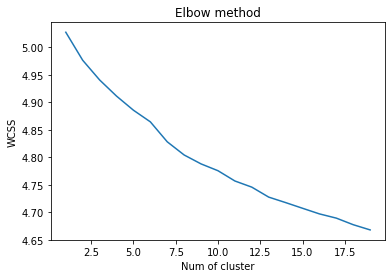

In [73]:
 plot_elbow (X_A)

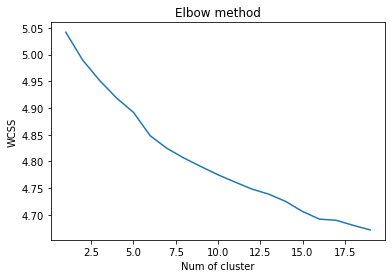

In [74]:
 plot_elbow (X_B)

In [75]:
def cluster_distribution(n_cluster, mean_vector):

    clf=KMeans(n_clusters=n_cluster, max_iter=100, init='k-means++', n_init=1)
    clf.fit(X_A)
    labels=clf.predict(X_A)

    anzahlen=pd.DataFrame(pd.Series(labels).value_counts(), columns=['num sentence']).T
    print(anzahlen)
    anzahlen.plot(kind='bar', figsize=(15,5))
    
    return labels


                 5    8    4    2    1    6    0    3   7
num sentence  1031  829  791  775  667  667  661  661  57


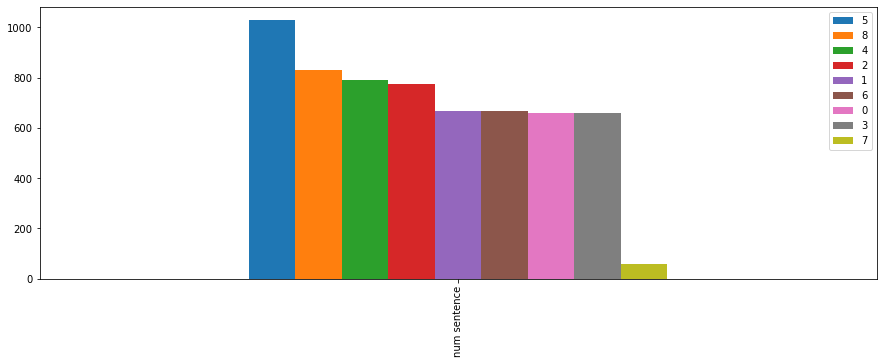

In [78]:
labels_A=cluster_distribution(9, X_A)

               14   7    13   6    4    1    8    9    2    10   11   3    5   \
num sentence  797  653  549  519  474  450  427  406  387  372  367  361  314   

              12  0   
num sentence  57   6  


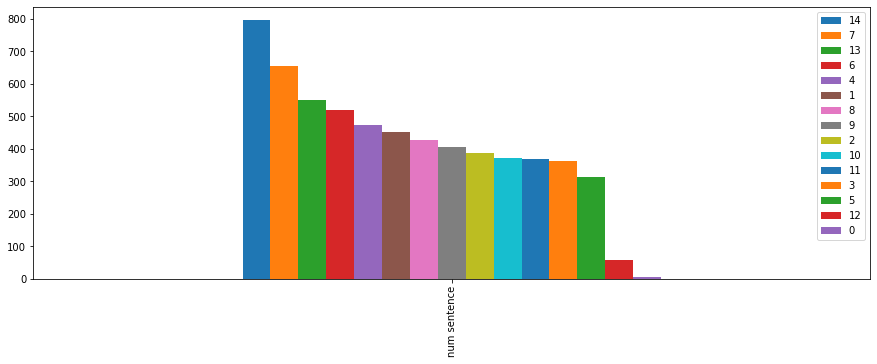

In [86]:
labels_B=cluster_distribution(15, X_B)

In [87]:
def obtain_tsne_graph (X, labels):
    X_embedded=TSNE(n_components=2).fit_transform(X)
    
    df_subset=pd.DataFrame()
    df_subset['tsne1']=X_embedded[:,0]
    df_subset['tsne2']=X_embedded[:,1]
    
    plt.figure(figsize=(16,10))
    sns.scatterplot(x='tsne1', y='tsne2', hue=labels, palette='deep', data=df_subset, legend='full', alpha=0.3)

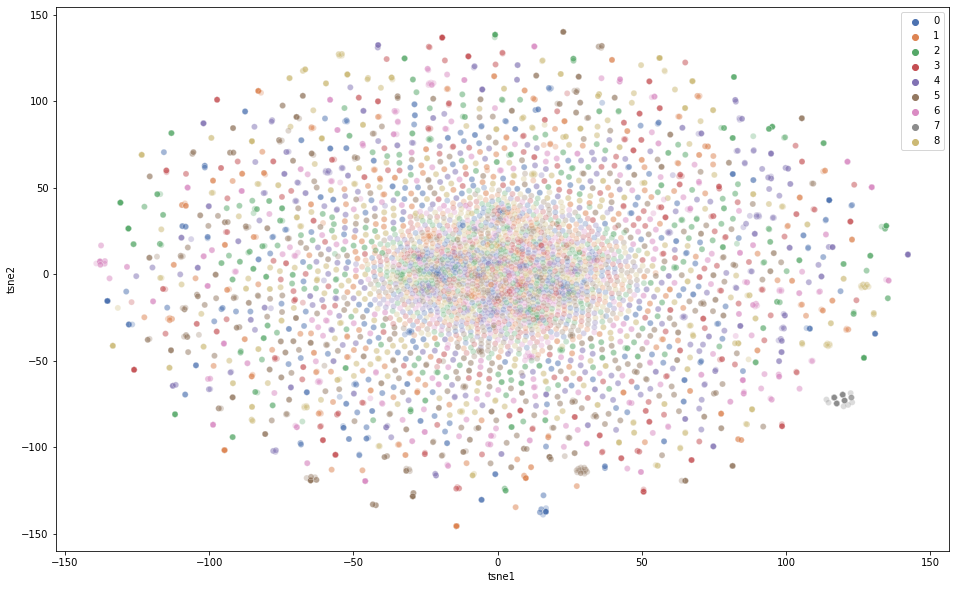

In [88]:
obtain_tsne_graph (X_A,labels_A)

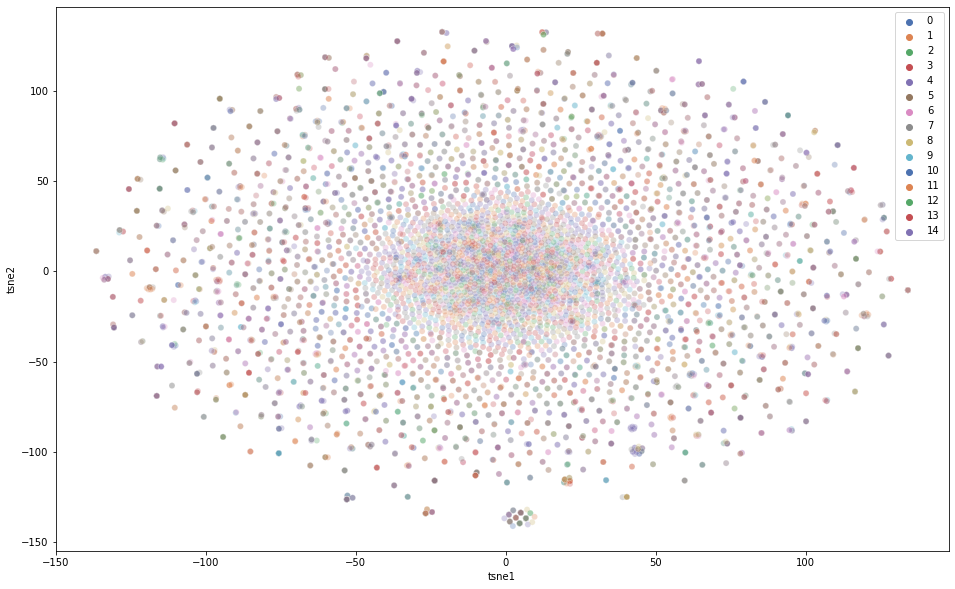

In [89]:
obtain_tsne_graph (X_B,labels_B)

In [90]:
df_final['cluster_A'] = labels_A

<ipython-input-90-bdbb2d1a5970>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['cluster_A'] = labels_A


In [91]:
df_final['cluster_B'] = labels_B

<ipython-input-91-626759e02d2e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['cluster_B'] = labels_B


In [97]:
df_final['same_cluster'] = np.where((df_final['cluster_A'] == df_final['cluster_B']) , 1, 0)

<ipython-input-97-c9c9130c721d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['same_cluster'] = np.where((df_final['cluster_A'] == df_final['cluster_B']) , 1, 0)


In [101]:
df_final.loc[df_final['same_cluster']==0]

,sentence_A,list_words_A,sentence_B,list_words_B,mean_vector_A,mean_vector_B,cluster_A,cluster_B,same_cluster
6,A group of boys in a yard is playing and a man...,[group boys yard playing standing backgroun],The young boys are playing outdoors and the ma...,[young boys playing outdoors smiling nearb],"[0.00458632, -4.335881e-05, -0.002258953, 0.00...","[-0.00042489267, -0.0044591483, 0.0024054102, ...",3,7,0
7,A group of children is playing in the house an...,[group children playing house standing backgroun],The young boys are playing outdoors and the ma...,[young boys playing outdoors smiling nearb],"[0.0039031773, -0.004155477, 0.0039385236, -0....","[-0.00042489267, -0.0044591483, 0.0024054102, ...",2,9,0
9,A brown dog is attacking another animal in fro...,[brown attacking another animal front tall pant],A brown dog is attacking another animal in fro...,[brown attacking another animal front pant],"[0.004548799, -0.003281978, -0.0009070612, 0.0...","[0.0045951344, -0.0008511946, -0.0032754284, -...",2,4,0
10,A brown dog is attacking another animal in fro...,[brown attacking another animal front pant],A brown dog is helping another animal in front...,[brown helping another animal front pant],"[0.0045951344, -0.0008511946, -0.0032754284, -...","[-0.004139448, 0.00082878943, 0.00022750092, 0...",0,14,0
12,Two dogs are wrestling and hugging,[two dogs wrestling huggin],There is no dog wrestling and hugging,[wrestling huggin],"[-0.0027077997, -0.004088973, 0.0048520816, -0...","[0.00042436158, -0.003347453, -0.0021687497, -...",8,7,0
...,...,...,...,...,...,...,...,...,...
9823,Two dogs are playing on the beach,[two dogs playing beac],Two people are driving a jeep and a lady is si...,[two people driving jeep lady sitting to],"[0.0023727883, 0.0044233464, -0.00092131353, -...","[-0.0018397898, -0.0028734435, -0.0047651418, ...",6,13,0
9824,A group of people in a large Asian restaurant ...,[group people large asian restaurant eatin],The cheerleaders are parading and wearing blac...,"[cheerleaders parading wearing black, pink wh...","[0.0034911437, -0.0004167338, -0.0030685642, -...","[-0.0010602365, 0.0025344098, 0.00059614715, -...",6,4,0
9836,Someone is boiling okra in a pot,[someone boiling okr],The man is not playing the drums,[playing drum],"[-0.0044942084, 0.0032852462, 0.0014603419, 0....","[-0.0014569409, 0.002354322, -0.0022324293, 0....",8,14,0
9838,A man in blue has a yellow ball in the mitt,[blue yellow bal],A man is jumping rope outside,[jumping rope outsid],"[0.0009835922, -0.0011584254, -0.00061018876, ...","[-0.0045813695, 0.0023293346, -0.0038899847, -...",1,10,0


<ipython-input-105-c9e5e2d35af0>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


IndexError: index 100 is out of bounds for axis 0 with size 100

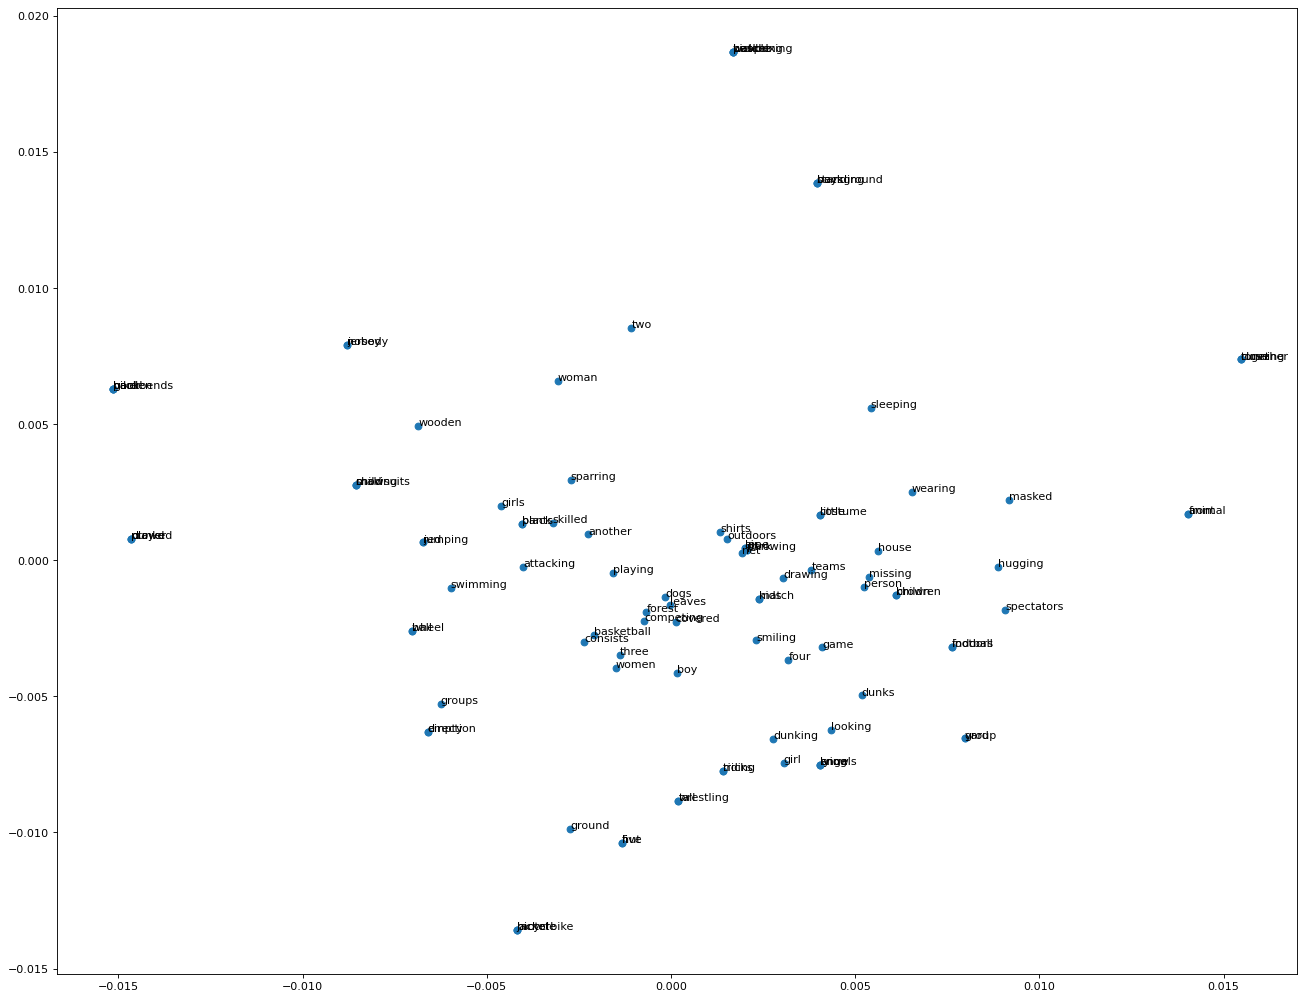

In [105]:
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X_A[0:100])
# create a scatter plot of the projection

figure(figsize=(20, 16), dpi=80)
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [109]:
model.wv.most_similar([ 'boys', 'playing'])

[('video', 0.6696327924728394),
 ('enthusiastically', 0.6634345054626465),
 ('games', 0.6251528263092041),
 ('men,', 0.6218937039375305),
 ('shirts', 0.6213285326957703),
 ('backbends', 0.6149892807006836),
 ('nearby', 0.6145997047424316),
 ('five', 0.613025963306427),
 ('twin', 0.6078796982765198),
 ('leg', 0.5894539952278137)]

 Clustering prediction given a sentence

In [114]:
sent=data['sent'].tolist()

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy



# vectorization of the texts
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(sent)
# used words (axis in our multi-dimensional space)
words = vectorizer.get_feature_names()
print("words", words)


n_clusters=10
number_of_seeds_to_try=10
max_iter = 300
number_of_process=2 # seads are distributed
model = KMeans(n_clusters=n_clusters, max_iter=max_iter, n_init=number_of_seeds_to_try, n_jobs=number_of_process).fit(X)

labels = model.labels_
# indices of preferible words in each cluster
ordered_words = model.cluster_centers_.argsort()[:, ::-1]

print("centers:", model.cluster_centers_)
print("labels", labels)
print("intertia:", model.inertia_)

texts_per_cluster = numpy.zeros(n_clusters)
for i_cluster in range(n_clusters):
    for label in labels:
        if label==i_cluster:
            texts_per_cluster[i_cluster] +=1 

print("Top words per cluster:")
for i_cluster in range(n_clusters):
    print("Cluster:", i_cluster, "texts:", int(texts_per_cluster[i_cluster])),
    for term in ordered_words[i_cluster, :10]:
        print("\t"+words[term])

print("\n")
print("Prediction")

text_to_predict = "i was riding a horse at the park?"
Y = vectorizer.transform([text_to_predict])
predicted_cluster = model.predict(Y)[0]
texts_per_cluster[predicted_cluster]+=1

print(text_to_predict)
print("Cluster:", predicted_cluster, "texts:", int(texts_per_cluster[predicted_cluster])),
for term in ordered_words[predicted_cluster, :10]:
    print("\t"+words[term])

words ['able', 'abruptly', 'absently', 'accessories', 'accident', 'acoustic', 'acrobatics', 'acting', 'activity', 'added', 'adding', 'adult', 'adults', 'advertisement', 'afghan', 'african', 'age', 'aged', 'aim', 'aiming', 'aimlessly', 'air', 'airborne', 'aircraft', 'airplane', 'aisle', 'alligator', 'allowed', 'alongside', 'amalgamating', 'amazedly', 'amazingly', 'american', 'amphitheater', 'amusedly', 'amusing', 'anchored', 'angels', 'angrily', 'angry', 'animal', 'animals', 'animated', 'animatedly', 'ankle', 'apparel', 'appealing', 'applying', 'approaching', 'arabic', 'arcade', 'area', 'areas', 'aren', 'arguing', 'arm', 'armbands', 'arms', 'arrangement', 'arranging', 'arriving', 'art', 'artificially', 'artist', 'arts', 'asia', 'asian', 'asleep', 'athletes', 'athletically', 'attached', 'attacking', 'attended', 'attentively', 'atvs', 'audience', 'austerely', 'automobile', 'awakening', 'away', 'axe', 'baby', 'backbends', 'background', 'backpack', 'backwards', 'backyard', 'badger', 'bag', 

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


centers: [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00031758 0.         0.         ... 0.00029473 0.         0.        ]
 [0.         0.         0.00128188 ... 0.         0.         0.00285519]
 ...
 [0.         0.         0.         ... 0.         0.00376593 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
labels [0 0 0 ... 1 4 6]
intertia: 11132.03455572564
Top words per cluster:
Cluster: 0 texts: 958
	playing
	flute
	man
	piano
	keyboard
	boy
	children
	cat
	dogs
	woman
Cluster: 1 texts: 4006
	people
	boy
	girl
	men
	jumping
	standing
	walking
	young
	sitting
	water
Cluster: 2 texts: 947
	person
	riding
	horse
	bike
	man
	motorcycle
	motorbike
	onion
	bicycle
	cutting
Cluster: 3 texts: 1365
	woman
	cutting
	eggs
	bowl
	man
	potato
	putting
	dancing
	peeling
	walking
Cluster: 4 texts: 2204
	man
	dancing
	standing
	cutting
	sitting
	doing
	rop

In [132]:
df_final_2=df_final

In [134]:
df_final_2['clsuter_A']=labels[:6139]

<ipython-input-134-5e13279c688c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_2['clsuter_A']=labels[:6139]


In [135]:
df_final_2['clsuter_B']=labels[6139:]

<ipython-input-135-ec7dd3ba5e26>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_2['clsuter_B']=labels[6139:]


In [136]:
df_final_2['same_cluster'] = np.where((df_final_2['clsuter_A'] == df_final_2['clsuter_B']) , 1, 0)

<ipython-input-136-a42ae26c0356>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_2['same_cluster'] = np.where((df_final_2['clsuter_A'] == df_final_2['clsuter_B']) , 1, 0)


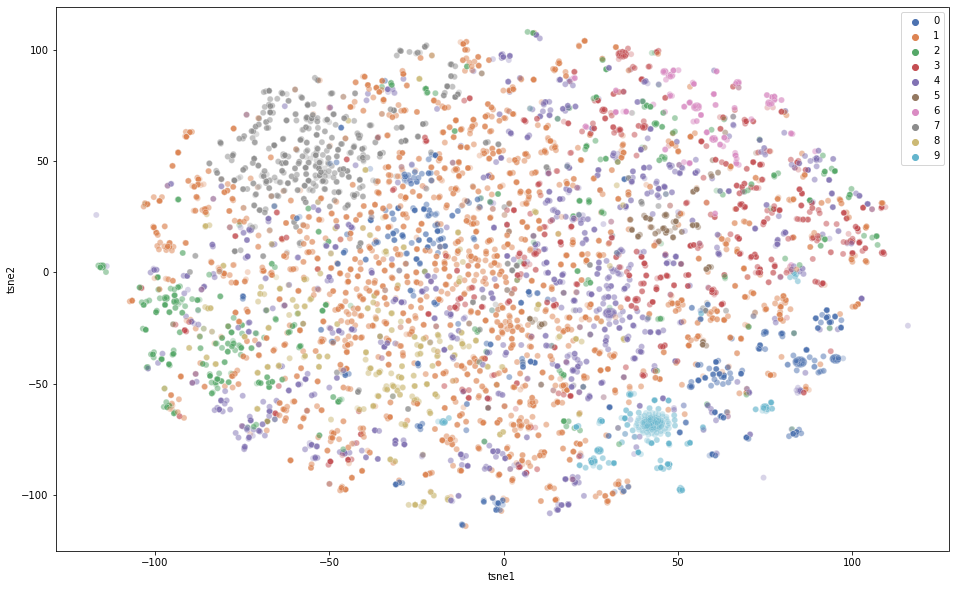

In [137]:
obtain_tsne_graph (X,labels)

In [138]:
df_final_2.loc[df_final_2['same_cluster']==1]

,sentence_A,list_words_A,sentence_B,list_words_B,mean_vector_A,mean_vector_B,cluster_A,cluster_B,same_cluster,clsuter_A,clsuter_B
5,There is no boy playing outdoors and there is ...,[boy playing outdoors smilin],A group of kids is playing in a yard and an ol...,[group kids playing yard old standing backgroun],"[0.0031318641, -0.0011349804, -0.0040294332, 0...","[-0.0039333664, -0.0022753812, -0.0008864912, ...",6,6,1,0,0
6,A group of boys in a yard is playing and a man...,[group boys yard playing standing backgroun],The young boys are playing outdoors and the ma...,[young boys playing outdoors smiling nearb],"[0.00458632, -4.335881e-05, -0.002258953, 0.00...","[-0.00042489267, -0.0044591483, 0.0024054102, ...",3,7,1,0,0
7,A group of children is playing in the house an...,[group children playing house standing backgroun],The young boys are playing outdoors and the ma...,[young boys playing outdoors smiling nearb],"[0.0039031773, -0.004155477, 0.0039385236, -0....","[-0.00042489267, -0.0044591483, 0.0024054102, ...",2,9,1,0,0
9,A brown dog is attacking another animal in fro...,[brown attacking another animal front tall pant],A brown dog is attacking another animal in fro...,[brown attacking another animal front pant],"[0.004548799, -0.003281978, -0.0009070612, 0.0...","[0.0045951344, -0.0008511946, -0.0032754284, -...",2,4,1,7,7
10,A brown dog is attacking another animal in fro...,[brown attacking another animal front pant],A brown dog is helping another animal in front...,[brown helping another animal front pant],"[0.0045951344, -0.0008511946, -0.0032754284, -...","[-0.004139448, 0.00082878943, 0.00022750092, 0...",0,14,1,7,7
...,...,...,...,...,...,...,...,...,...,...,...
9787,A great singer is dancing on the ceiling,[great singer dancing ceilin],A child is making a snow ball,[child making snow bal],"[0.003638111, -0.0016692056, -0.0013980774, 0....","[0.001586644, -0.0026027183, 0.0046218727, -0....",5,7,1,1,1
9788,The man is doing a wheelie on a mountain bike,[wheelie mountain bik],A man is stopping in the middle of a road,[stopping middle roa],"[0.003802226, -0.003995458, 0.0035344437, -0.0...","[0.00044082204, -0.0016657755, -0.00066715287,...",5,3,1,4,4
9794,"Two men are doing a skit, which is very funny,...","[two skit, funny, boxer front crowd peopl]",A rabbit is playing with a toy rabbit,[rabbit playing toy rabbi],"[0.00022605178, -0.0017951863, -0.00029579594,...","[-0.004273442, -0.0013623678, 0.0046417424, 0....",1,7,1,1,1
9812,The military officer is shouting at the recruits,[military officer shouting recruit],A rollerblader is performing a trick on a ramp,[rollerblader performing trick ram],"[0.000101483834, 0.000577015, -0.0023440712, -...","[-0.0028609952, -0.0017354392, -0.0020504624, ...",1,6,1,1,1


In [139]:
df_final_2.loc[df_final_2['same_cluster']==0]

,sentence_A,list_words_A,sentence_B,list_words_B,mean_vector_A,mean_vector_B,cluster_A,cluster_B,same_cluster,clsuter_A,clsuter_B
12,Two dogs are wrestling and hugging,[two dogs wrestling huggin],There is no dog wrestling and hugging,[wrestling huggin],"[-0.0027077997, -0.004088973, 0.0048520816, -0...","[0.00042436158, -0.003347453, -0.0021687497, -...",8,7,0,1,7
15,Two dogs are wrestling and hugging,[two dogs wrestling huggin],A brown dog is attacking another animal in fro...,[brown attacking another animal front tall pant],"[-0.0027077997, -0.004088973, 0.0048520816, -0...","[0.004548799, -0.003281978, -0.0009070612, 0.0...",8,7,0,1,7
16,Two dogs are wrestling and hugging,[two dogs wrestling huggin],A brown dog is helping another animal in front...,[brown helping another animal front pant],"[-0.0027077997, -0.004088973, 0.0048520816, -0...","[-0.004139448, 0.00082878943, 0.00022750092, 0...",8,7,0,1,7
18,A person in a black jacket is doing tricks on ...,[person black jacket tricks motorbik],A man in a black jacket is doing tricks on a m...,[black jacket tricks motorbik],"[-0.004775509, -0.0024020013, -0.0016333779, 0...","[-0.0041228207, 0.0018191756, -0.00217861, 0.0...",1,10,0,2,4
19,There is no man in a black jacket doing tricks...,[black jacket tricks motorbik],A person in a black jacket is doing tricks on ...,[person black jacket tricks motorbik],"[-0.0041228207, 0.0018191756, -0.00217861, 0.0...","[-0.004775509, -0.0024020013, -0.0016333779, 0...",8,10,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...
9824,A group of people in a large Asian restaurant ...,[group people large asian restaurant eatin],The cheerleaders are parading and wearing blac...,"[cheerleaders parading wearing black, pink wh...","[0.0034911437, -0.0004167338, -0.0030685642, -...","[-0.0010602365, 0.0025344098, 0.00059614715, -...",6,4,0,5,8
9832,A door is being opened by a man,[opene],A bald man in a band is playing guitar in the ...,[bald band playing guitar spotligh],"[0.0020662863, -0.001952145, -0.00273897, 0.00...","[-0.003168029, -0.00478086, 0.00083957904, -0....",8,8,0,4,0
9836,Someone is boiling okra in a pot,[someone boiling okr],The man is not playing the drums,[playing drum],"[-0.0044942084, 0.0032852462, 0.0014603419, 0....","[-0.0014569409, 0.002354322, -0.0022324293, 0....",8,14,0,1,0
9837,The man is singing heartily and playing the gu...,[singing heartily playing guita],A bicyclist is holding a bike over his head in...,[bicyclist holding bike head group peopl],"[0.0033966296, 0.0023605155, -0.0039255666, -0...","[-0.0006427725, 0.0029305457, -0.0025698317, 0...",5,5,0,9,1
